# Quantum Evolution Kernal for Earth Observation
This notebook uses `qutip` as a backend for running the simulations. It can be run locally.

In [1]:
import qsvm4eo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the data
num_features = 4  # the number of features to use (4 or 8)
x_train, y_train, x_test, y_test, label_names = qsvm4eo.load_data(
    data_path="..", num_features=num_features, scale_features=True
)

# Encode the data, transforming the features into qubit coordinates
radial_shift = 1.0  # radial encoding shift
radial_scaling = 5.4  # radial encoding scaling
encoding = qsvm4eo.RadialEncoding(
    max_feature=np.max(x_train),
    shift=radial_shift,
    scaling=radial_scaling,
    n_features=num_features,
)
qbits_train = [encoding.encode(x) for x in x_train]
qbits_test = [encoding.encode(x) for x in x_test]

In [3]:
# Use the qutip backend to evolve the quantum system.
duration = 0.66  # the amount of time to evolve the system
qpu_qutip = qsvm4eo.QutipBackend(duration=duration)
probs_train = qpu_qutip.batch(qbits_train)
probs_test = qpu_qutip.batch(qbits_test)

# Commpute the excitation probability distribution from the state
# distribution.
excitations_train = qsvm4eo.compute_excitation_count(probs_train)
excitations_test = qsvm4eo.compute_excitation_count(probs_test)

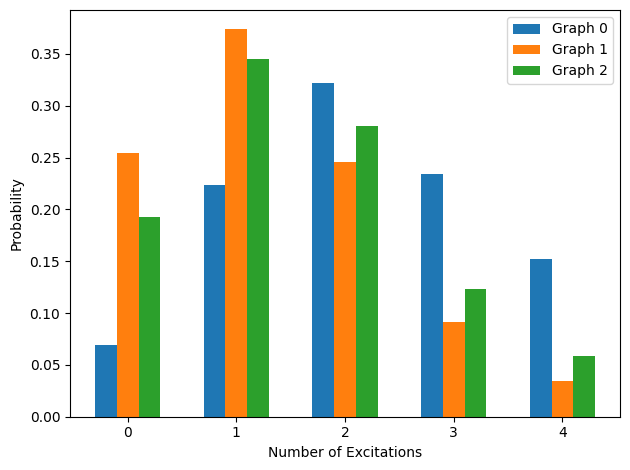

In [4]:
# Plot the probability of the states being measured
x = np.arange(num_features + 1)
width = 0.2
for c in range(3):
    plt.bar(
        x + (2 * c - 2) * width * 0.5,
        excitations_train[c],
        width=width,
        label="Graph %i" % c,
    )
plt.xlabel("Number of Excitations")
plt.ylabel("Probability")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compute the kernel and train the model
kernel = qsvm4eo.Kernel(mu=1)
gram_train = kernel.compute_gram_train(excitations_train)

model = qsvm4eo.QSVM(regularization=20.0)
train_score = model.train(gram_train, y_train)
print("Train acc:", train_score)

gram_test = kernel.compute_gram_test(excitations_train, excitations_test)
y_test_pred = model.predict(gram_test)
print("Test acc:", (y_test_pred == y_test).mean())

Train acc: 0.8896484375
Test acc: 0.5556640625


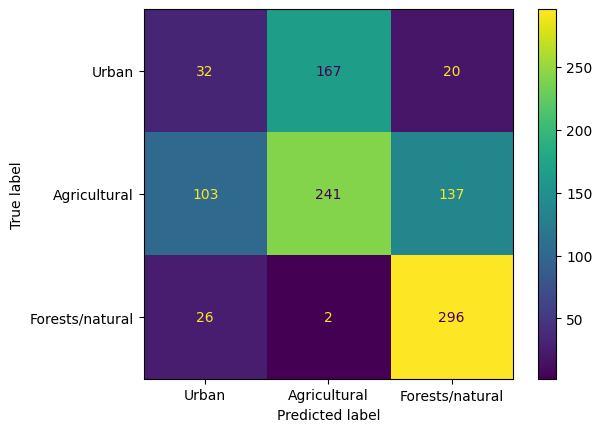

In [7]:
# Plot the confusion matrix for the test data.
conf_mat = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names.values())
disp.plot()
plt.show()